## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [109]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [110]:
# do not change the code in the block below
# __________start of block__________


def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        layer_name, params = layer_str.split("(", 1)
        params = params.rstrip(")")
        layer_info["type"] = layer_name.strip()
        param_dict = {}
        for param in params.split(", "):
            if "=" in param:
                key, value = param.split("=")
                param_dict[key.strip()] = eval(value.strip())
            else:
                param_dict[param.strip()] = None
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict


# __________end of block__________

In [111]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [112]:
# !wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict.npy

In [113]:
# # do not change the code in the block below
# # __________start of block__________
# assert os.path.exists(
#     "hw_overfitting_data_dict.npy"
# ), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# # __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [114]:
CUDA_DEVICE_ID = 0  # change if needed

In [115]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: 1')

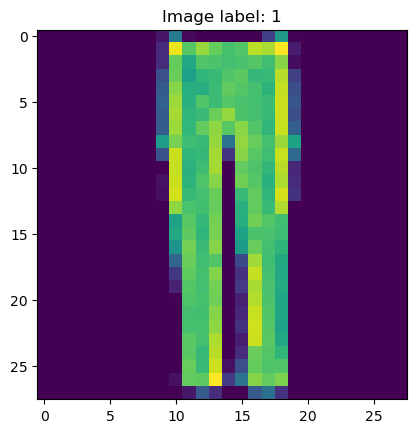

In [116]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=0
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [117]:
# Improved data augmentation and normalization
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.2860,), (0.3530,))  # FashionMNIST mean and std
])

# Apply only normalization to test data
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.2860,), (0.3530,))
])

# Reload datasets with transforms
train_fmnist_data = FashionMNIST(
    ".", train=True, transform=train_transform, download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=test_transform, download=True
)

# Recreate data loaders with larger batch size for efficiency
train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=128, shuffle=True, num_workers=0
)
test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=128, shuffle=False, num_workers=0
)

In [118]:
# Creating model instance
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(16),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 14 * 14, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax(dim=1)  # Output layer with softmax activation for multi-class classification
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_task_1 = model.to(device)

Не забудьте перенести модель на выбранный `device`!

Локальные тесты для проверки вашей модели доступны ниже:

In [119]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [120]:
# Training parameters with learning rate scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/20, Train Loss: 1.7120, Train Acc: 75.92%, Val Loss: 1.6369, Val Acc: 82.69%
Epoch: 2/20, Train Loss: 1.6521, Train Acc: 81.22%, Val Loss: 1.6208, Val Acc: 84.25%
Epoch: 3/20, Train Loss: 1.6430, Train Acc: 81.98%, Val Loss: 1.6221, Val Acc: 83.78%
Epoch: 4/20, Train Loss: 1.6352, Train Acc: 82.75%, Val Loss: 1.6122, Val Acc: 84.99%
Epoch: 5/20, Train Loss: 1.6320, Train Acc: 83.01%, Val Loss: 1.6160, Val Acc: 84.55%
Epoch: 6/20, Train Loss: 1.6266, Train Acc: 83.55%, Val Loss: 1.6331, Val Acc: 82.65%
Epoch: 7/20, Train Loss: 1.6249, Train Acc: 83.73%, Val Loss: 1.6065, Val Acc: 85.65%
Epoch: 8/20, Train Loss: 1.6237, Train Acc: 83.82%, Val Loss: 1.6054, Val Acc: 85.64%
Epoch: 9/20, Train Loss: 1.6213, Train Acc: 84.12%, Val Loss: 1.6042, Val Acc: 85.63%
Epoch: 10/20, Train Loss: 1.6190, Train Acc: 84.31%, Val Loss: 1.5973, Val Acc: 86.48%
Epoch: 11/20, Train Loss: 1.6171, Train Acc: 84.52%, Val Loss: 1.6027, Val Acc: 85.85%
Epoch: 12/20, Train Loss: 1.6163, Train Acc: 84.56%,

/var/folders/7x/qwc250892l7d293_cbs51c4r0000gn/T/ipykernel_19612/2806475377.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_task_1.load_state_dict(torch.load('bes

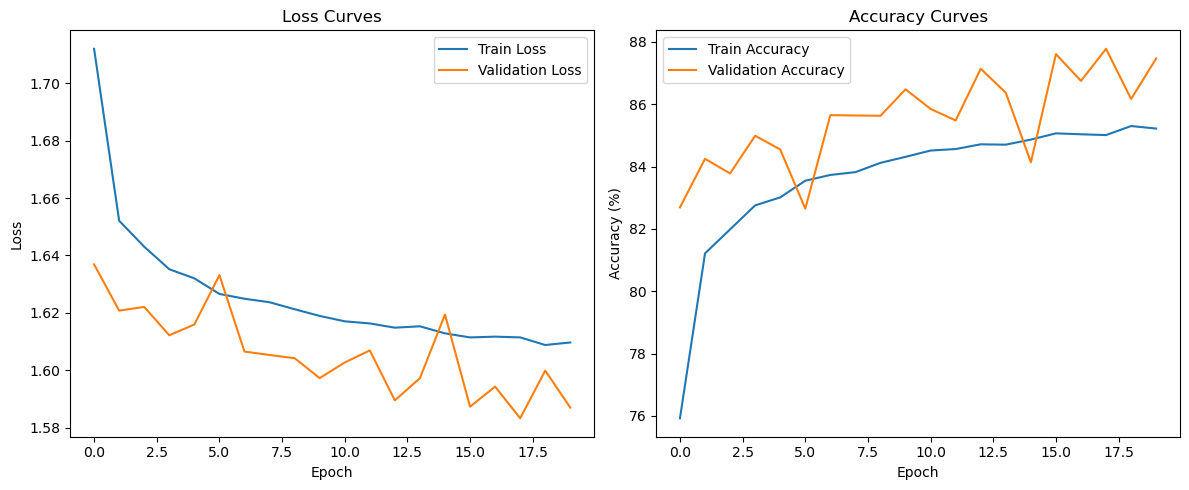

In [121]:
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early stopping parameters
best_val_acc = 0
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model_task_1.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch_index, (images, labels) in enumerate(train_data_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_task_1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_data_loader)
    epoch_accuracy = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    # Validation phase
    model_task_1.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_task_1(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_epoch_loss = val_loss / len(test_data_loader)
    val_epoch_accuracy = 100. * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    # Update learning rate based on validation loss
    scheduler.step(val_epoch_loss)
    
    # Print epoch statistics
    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}%')
    
    # Early stopping check
    if val_epoch_accuracy > best_val_acc:
        best_val_acc = val_epoch_accuracy
        patience_counter = 0
        # Save the best model
        torch.save(model_task_1.state_dict(), 'best_fmnist_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

# Load the best model
model_task_1.load_state_dict(torch.load('best_fmnist_model.pth'))
print('Training complete!')

# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [122]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.85908


In [123]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8778


Проверка, что необходимые пороги пройдены:

In [124]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

AssertionError: Train accuracy is below 0.885 threshold

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!